In [23]:
#Basic libraries
import pandas as pd 
import numpy as np 

#Visualization libraries
import matplotlib.pyplot as plt 
import seaborn as sns
from textblob import TextBlob
import cufflinks as cf
%matplotlib inline

#NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Machine Learning libraries
import sklearn
from sklearn.model_selection import train_test_split

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

#Deep learning libraries
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

#Miscellanous libraries
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
!pip install chart_studio
import chart_studio.plotly as py

     |████████████████████████████████| 64 kB 2.0 MB/s 


In [3]:
#reading the fake and true datasets
fake_news = pd.read_csv('/content/drive/MyDrive/NLP/Fake_classifier/Fake.csv')
true_news = pd.read_csv('/content/drive/MyDrive/NLP/Fake_classifier/True.csv')

# print shape of fake dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(fake_news.shape))
print (fake_news.info())
print("\n --------------------------------------- \n")

# print shape of true dataset with rows and columns and information
print ("The shape of the  data is (row, column):"+ str(true_news.shape))
print (true_news.info())

The shape of the  data is (row, column):(23481, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None

 --------------------------------------- 

The shape of the  data is (row, column):(21417, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


In [4]:
#Creating target variable for fake news aand real news as '0' and '1' respectively
fake_news['output']=0
true_news['output']=1

In [5]:
##Treating news subject and news title seperately will not present the whole issue and hence wud'nt make much success
#Concatenating and dropping for fake news
fake_news['news']=fake_news['title']+fake_news['text']
fake_news=fake_news.drop(['title', 'text'], axis=1)

#Concatenating and dropping for true news
true_news['news']=true_news['title']+true_news['text']
true_news=true_news.drop(['title', 'text'], axis=1)

#Rearranging the columns
fake_news = fake_news[['subject', 'date', 'news','output']]
true_news = true_news[['subject', 'date', 'news','output']]

In [6]:
fake_news['date'].value_counts()

May 10, 2017                                                                                                                                         46
May 26, 2016                                                                                                                                         44
May 5, 2016                                                                                                                                          44
May 6, 2016                                                                                                                                          44
May 11, 2016                                                                                                                                         43
                                                                                                                                                     ..
https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-

In [7]:
true_news['date'].value_counts()

December 20, 2017     182
December 6, 2017      166
November 30, 2017     162
November 9, 2017      158
October 13, 2017      155
                     ... 
December 30, 2017       1
May 30, 2016            1
January 24, 2016        1
September 3, 2016       1
December 25, 2016       1
Name: date, Length: 716, dtype: int64

In [8]:
#As observed from the above cells, only fake news has links and headlines inside date column. This is an issue that has to be resolved.
fake_news=fake_news[fake_news.date.str.contains("Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec")]

In [9]:
#Converting the date to datetime format
fake_news['date'] = pd.to_datetime(fake_news['date'])
true_news['date'] = pd.to_datetime(true_news['date'])


In [10]:
#It is better to provide the model, data in a single file.Hence Icombine the files here for further processing and EDA
frames = [fake_news, true_news]
news_dataset = pd.concat(frames)
news_dataset

,subject,date,news,output
0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’...,0
1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian ...,0
2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke...,0
3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Dur...,0
...,...,...,...,...
21412,worldnews,2017-08-22,'Fully committed' NATO backs new U.S. approach...,1
21413,worldnews,2017-08-22,LexisNexis withdrew two products from Chinese ...,1
21414,worldnews,2017-08-22,Minsk cultural hub becomes haven from authorit...,1
21415,worldnews,2017-08-22,Vatican upbeat on possibility of Pope Francis ...,1


In [11]:
##Preprocesing to remove punctuation
clean_news=news_dataset.copy()
def review_cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
    clean_news['news']=clean_news['news'].apply(lambda x:review_cleaning(x))
clean_news.head()

,subject,date,news,output
0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’...,0
1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian ...,0
2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke...,0
3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Dur...,0


In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
stop = stopwords.words('english')
clean_news['news'] = clean_news['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

,subject,date,news,output
0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’s...,0
1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian C...,0
2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke ...,0
3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name ...,0
4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Duri...,0


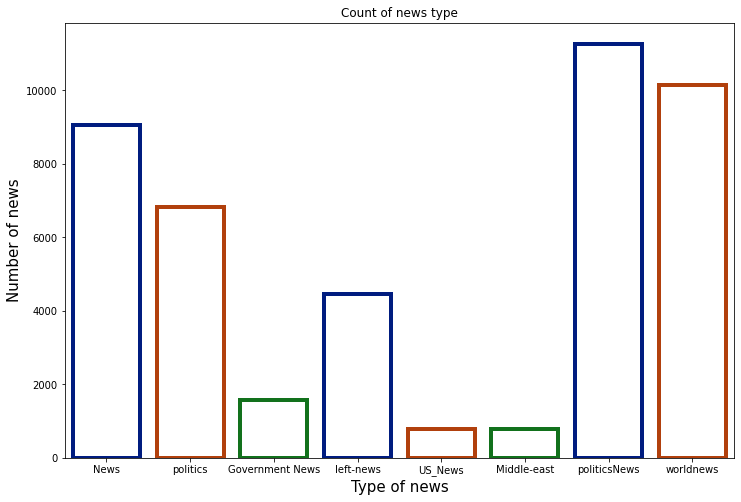

In [18]:
#Plotting the frequency plot
plt.figure(figsize=(12,8))
ax = sns.countplot(x="subject", data=clean_news,
                   facecolor=(0, 0, 0, 0),
                   linewidth=4,
                   edgecolor=sns.color_palette("dark", 3))

#Setting labels and font size
ax.set(xlabel='Type of news', ylabel='Number of news',title='Count of news type')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

**Insights:**


*   Looks like our dataset has more political and world news compared to any other topic
*   Also seems like the classes have been repeated



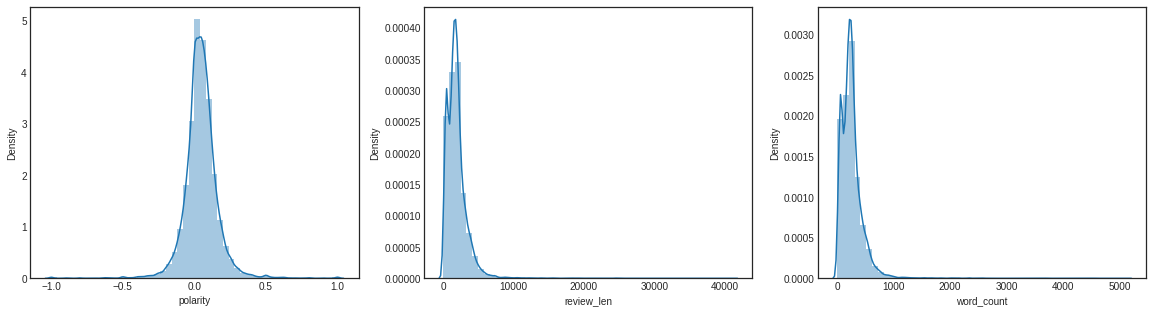

In [20]:
#Extracting the features from the news
clean_news['polarity'] = clean_news['news'].map(lambda text: TextBlob(text).sentiment.polarity)
clean_news['review_len'] = clean_news['news'].astype(str).apply(len)
clean_news['word_count'] = clean_news['news'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(clean_news['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(clean_news['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(clean_news['word_count'])
fig = plt.gcf()

In [21]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(clean_news['news'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df1.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in news')

trump 148219
said 133030
the 124608
president 57308
would 55660
it 46062
people 42426
one 38587
state 35506
in 34573
new 32270
also 31394
obama 31305
clinton 30392
reuters 29561
house 29415
he 29264
government 28595
donald 28375
states 27076


Exception: ignored

In [ ]:
#Creating the count of output based on date
fake=fake_news.groupby(['date'])['output'].count()
fake=pd.DataFrame(fake)

true=true_news.groupby(['date'])['output'].count()
true=pd.DataFrame(true)

#Plotting the time series graph
fig = go.Figure()
fig.add_trace(go.Scatter(
         x=true.index,
         y=true['output'],
         name='True',
    line=dict(color='blue'),
    opacity=0.8))

fig.add_trace(go.Scatter(
         x=fake.index,
         y=fake['output'],
         name='Fake',
    line=dict(color='red'),
    opacity=0.8))

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
        
    
fig.update_layout(title_text='True and Fake News',plot_bgcolor='rgb(248, 248, 255)',yaxis_title='Value')

fig.show()

In [ ]:
#Extracting 'reviews' for processing
news_features=clean_news.copy()
news_features=news_features[['news']].reset_index(drop=True)
news_features.head()

,news
0,Donald Trump Sends Out Embarrassing New Year’s...
1,Drunk Bragging Trump Staffer Started Russian C...
2,Sheriff David Clarke Becomes An Internet Joke ...
3,Trump Is So Obsessed He Even Has Obama’s Name ...
4,Pope Francis Just Called Out Donald Trump Duri...


In [ ]:
stop_words = set(stopwords.words("english"))
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['news'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news)#Getting the target variable
y=clean_news['output']

In [ ]:
#Setting up vocabulary size
voc_size=10000

#One hot encoding 
onehot_repr=[one_hot(words,voc_size)for words in corpus]

In [ ]:
#Setting sentence length
sent_length=5000

#Padding the sentences
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 9976 5029 1621]
 [   0    0    0 ... 3987 5029 1621]
 [   0    0    0 ... 5012 5029 1621]
 ...
 [   0    0    0 ... 5568 3500 2527]
 [   0    0    0 ... 2359 8290 3554]
 [   0    0    0 ... 6746 7779 5214]]


In [ ]:
#Creating the lstm model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100)) #Adding 100 lstm neurons in the layer
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 40)          400000    
                                                                 
 dropout (Dropout)           (None, 5000, 40)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 456,501
Trainable params: 456,501
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Converting the X and y as array
X_final=np.array(embedded_docs)
y_final=np.array(y)

#Check shape of X and y final
X_final.shape,y_final.shape

((44888, 5000), (44888,))

In [ ]:
# Train test split of the X and y final
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# Fitting with 10 epochs and 64 batch size
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
470/470 [==============================] - 338s 704ms/step - loss: 0.1537 - accuracy: 0.9409 - val_loss: 0.0540 - val_accuracy: 0.9843
Epoch 2/10
470/470 [==============================] - 328s 699ms/step - loss: 0.0509 - accuracy: 0.9857 - val_loss: 0.0721 - val_accuracy: 0.9752
Epoch 3/10
470/470 [==============================] - 329s 699ms/step - loss: 0.0713 - accuracy: 0.9776 - val_loss: 0.0833 - val_accuracy: 0.9715
Epoch 4/10
470/470 [==============================] - 329s 700ms/step - loss: 0.2296 - accuracy: 0.9394 - val_loss: 0.0921 - val_accuracy: 0.9665
Epoch 5/10
470/470 [==============================] - 329s 701ms/step - loss: 0.0528 - accuracy: 0.9849 - val_loss: 0.0572 - val_accuracy: 0.9838
Epoch 6/10
470/470 [==============================] - 329s 701ms/step - loss: 0.0445 - accuracy: 0.9864 - val_loss: 0.0788 - val_accuracy: 0.9727
Epoch 7/10
470/470 [==============================] - 330s 702ms/step - loss: 0.0240 - accuracy: 0.9935 - val_loss: 0.0547 -

In [ ]:
# Predicting from test data
y_pred=(model.predict(X_test) > 0.5).astype("int32")
#Creating confusion matrix
confusion_matrix(y_test,y_pred)
#cm = metrics.confusion_matrix(y_test, y_pred)
#plot_confusion_matrix(X=y_test, y_true=y_pred,labels=['Fake','True'])

array([[7570,  207],
       [  52, 6985]])

In [ ]:
#Checking for accuracy
accuracy_score(y_test,y_pred)

0.9825165384096125

In [ ]:
# Creating classification report 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7777
           1       0.97      0.99      0.98      7037

    accuracy                           0.98     14814
   macro avg       0.98      0.98      0.98     14814
weighted avg       0.98      0.98      0.98     14814



In [ ]:
import pickle
pickle.dump(model,open('/content/drive/MyDrive/NLP/Fake_classifier/fake_news_classifier.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://073371d9-b84c-47e2-a566-51ca938ed00e/assets


INFO:tensorflow:Assets written to: ram://073371d9-b84c-47e2-a566-51ca938ed00e/assets


In [ ]:
import os
os.listdir('.')

['.config', 'drive', 'fake_news_classifier.pkl', 'sample_data']